In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import warnings
import time
import os
import scipy.io
from tqdm import tqdm
from solver import train, test
from plot import plot_loss
from eventDataset import eqkDataset
warnings.filterwarnings("ignore")
sns.set_style('ticks')
# sns.set()
sns.set_context("talk")
plt.rcParams['font.sans-serif'] = 'Times New Roman'
torch.set_default_tensor_type(torch.DoubleTensor)

## 导入数据

In [2]:
station = 'TKCH08'
dhacc = 981 * np.load(station + '_dhacc.npy')
upacc = 981 * np.load(station + '_upacc.npy')
# mdacc = 981 * np.load(station + '_mdacc.npy')

dt = 0.02
t = np.linspace(dt, dt * dhacc.shape[1], dhacc.shape[1])

In [3]:
# 用井下地震动的PGA进行数据标准化
PGA_dh = np.max(np.abs(dhacc), axis=1)
PGA_up = np.max(np.abs(upacc), axis=1)
for i in range(dhacc.shape[0]):
    dhacc[i, :] = dhacc[i, :] / PGA_dh[i]
    upacc[i, :] = upacc[i, :] / PGA_dh[i]

(Text(0.5, 0, 't (s)'),
 Text(0, 0.5, 'acc (g)'),
 <matplotlib.legend.Legend at 0x22ca2f8f808>)

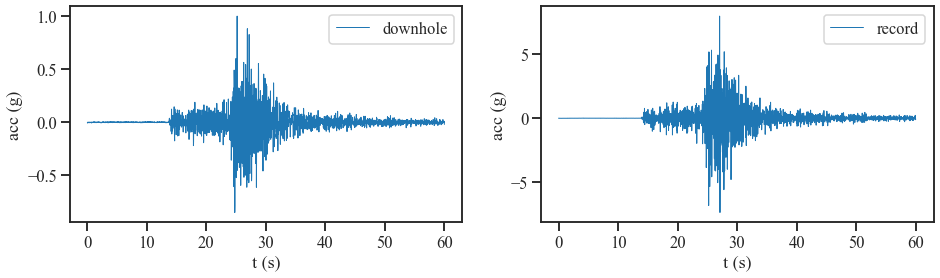

In [4]:
i = 23
t = np.linspace(0.02, 60, 3000)
plt.figure(figsize=((12, 3)))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
plt.subplot(1, 2, 1)
plt.plot(t, dhacc[i, :], label='downhole', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (g)'), plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
# plt.plot(t, mdacc[i, :], '--', label='simulate', linewidth=1)
plt.plot(t, upacc[i, :], label='record', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (g)'), plt.legend(loc='upper right')

## 构造求导矩阵

In [5]:
n = dhacc.shape[1]
phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n - 3, ])])
temp1 = np.concatenate([-1 / 2 * np.identity(n - 2), np.zeros([n - 2, 2])], axis=1)
temp2 = np.concatenate([np.zeros([n - 2, 2]), 1 / 2 * np.identity(n - 2)], axis=1)
phi2 = temp1 + temp2
phi3 = np.concatenate([np.zeros([n - 3, ]), np.array([1 / 2, -2, 3 / 2])])
Phi_t = 1 / dt * np.concatenate([np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)
Phi_t = torch.tensor(Phi_t)

## 构建神经网络模型

In [6]:
class PhyRNN(nn.Module):
    def __init__(self, Phi_t, input_size, hidden_size, num_layers):
        if torch.cuda.is_available():
            Phi_t = Phi_t.cuda()
        self.Phi_t = Phi_t
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        super(PhyRNN, self).__init__()
        self.rnnlayer = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 4),
            nn.ReLU(inplace=True),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        x, (ht, ct) = self.rnnlayer(x)
        x = self.fc(x)
        x_t = torch.matmul(self.Phi_t, x[:, :, 0].permute(1, 0))
        x_tt = torch.matmul(self.Phi_t, x_t)
        # x_tt = x_tt.reshape((x_tt.shape[0], x_tt.shape[1], 1))
        return x, x_t.permute(1, 0), x_tt.permute(1, 0)

In [7]:
def PhyCNNLoss(output, output_tt, target):
    # PGA = torch.max(torch.abs(output_tt))/100
    # loss = torch.mean((output_tt/PGA - target/PGA).pow(2))
    loss = torch.mean((output_tt - target).pow(2))
    # loss = torch.mean((output_tt - target).pow(2)) + torch.mean(output.pow(2))
    return loss

In [8]:
batch_size = 64
valid_size = 0.1
test_size = 0.1
k_fold = 5
max_epoch = 200
disp_freq = 10
learning_rate = 0.001

numdata = dhacc.shape[0]
k_len = int(numdata / k_fold)
index = list(range(numdata))
np.random.shuffle(index)
all_idx = []
for i in range(k_fold):
    if i == 0:
        all_idx.append(index[:k_len * (i+1)])
    elif i == k_fold - 1:
        all_idx.append(index[i * k_len:])
    else:
        all_idx.append(index[i * k_len : (i+1) * k_len])

output_all = []
test_loss_all = []
for i, test_idx in enumerate(all_idx):
    train_idx = list(set(index) - set(test_idx))
    valid_idx = train_idx[:k_len]
    train_data, train_label = dhacc[train_idx, :, None], upacc[train_idx]
    valid_data, valid_label = dhacc[valid_idx, :, None], upacc[valid_idx]
    test_data, test_label = dhacc[test_idx, :, None], upacc[test_idx]

    train_dataset = eqkDataset(train_data, train_label)
    valid_dataset = eqkDataset(valid_data, valid_label)
    test_dataset = eqkDataset(test_data, test_label)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset)
    test_loader = torch.utils.data.DataLoader(test_dataset)

    Net = PhyRNN(Phi_t, 1, 64, 3)
    # GPU加速
    if torch.cuda.is_available():
        Net = Net.cuda()
    # optimizer = torch.optim.LBFGS(Net.parameters(), lr=learning_rate, max_iter=2)
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    starttime = time.time()
    train_best_model ,valid_best_model, last_model, train_loss, valid_loss = train(Net, PhyCNNLoss, optimizer, train_loader, valid_loader, max_epoch, disp_freq)
    print('{:d} Fold: Training Time {:.4f}'.format(i, time.time()-starttime))
    prediction, test_loss = test(valid_best_model, PhyCNNLoss, test_loader)
    torch.cuda.empty_cache()
    output_all.append([train_best_model ,valid_best_model, last_model, train_loss, valid_loss])
    test_loss_all.append(test_loss)

Epoch [1/200]	 Average training and validation loss: 5.7526E-01 6.1645E-01	Time: 14.00s
Epoch [2/200]	 Average training and validation loss: 5.7099E-01 6.1511E-01	Time: 13.32s
Epoch [3/200]	 Average training and validation loss: 5.6941E-01 6.1496E-01	Time: 13.17s
Epoch [4/200]	 Average training and validation loss: 5.6843E-01 6.1142E-01	Time: 13.27s
Epoch [5/200]	 Average training and validation loss: 5.6581E-01 6.0731E-01	Time: 13.16s
Epoch [6/200]	 Average training and validation loss: 5.6279E-01 6.0209E-01	Time: 13.14s
Epoch [7/200]	 Average training and validation loss: 5.5858E-01 5.9467E-01	Time: 13.17s
Epoch [8/200]	 Average training and validation loss: 5.5377E-01 5.8705E-01	Time: 13.27s
Epoch [9/200]	 Average training and validation loss: 5.4959E-01 5.8318E-01	Time: 13.09s
Epoch [10/200]	 Average training and validation loss: 5.4855E-01 5.8226E-01	Time: 13.15s
Epoch [11/200]	 Average training and validation loss: 5.4708E-01 5.8050E-01	Time: 13.10s
Epoch [12/200]	 Average traini

(Text(0.5, 0, 'k'), Text(0, 0.5, 'Test Loss'))

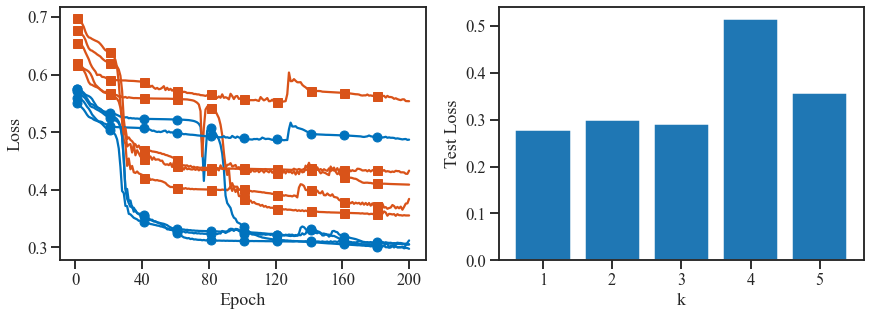

In [9]:
fig = plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.05,bottom=0.1,top=0.98,right=0.98,hspace=0.22,wspace=0.2)
plt.subplot(1, 2, 1)
for i in range(k_fold):
    plt.plot(range(1, 1 + max_epoch), output_all[i][3], label='train', marker='o', color='#0072BD', markevery=int(max_epoch / 10))
    plt.plot(range(1, 1 + max_epoch), output_all[i][4], label='train', marker='s', color='#D95319', markevery=int(max_epoch / 10))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0, max_epoch + 1, int(max_epoch / 5)))

plt.subplot(1, 2, 2)
plt.bar(np.arange(k_fold) + 1,[float(a.cpu().detach()) for a in test_loss_all])
plt.xlabel('k'), plt.ylabel('Test Loss')

In [ ]:
train_pred = np.zeros(train_data.shape)
train_pred_t = np.zeros(train_data[:, :, 0].shape)
train_pred_tt = np.zeros(train_data[:, :, 0].shape)
pbar = tqdm(range(train_data.shape[0]), desc='计算中', ncols=100)
for i in pbar:
    y, y_t, y_tt = valid_best_model(torch.tensor(train_data[i:i+1, :, :]).cuda())
    train_pred[i, :, :] = y.cpu().detach().numpy()
    train_pred_t[i, :] = y_t.cpu().detach().numpy()
    train_pred_tt[i, :] = y_tt.cpu().detach().numpy()
    train_data[i, :, 0] = train_data[i, :, 0] * PGA_dh[train_idx[i]]
    train_pred_tt[i, :] = train_pred_tt[i, :] * PGA_dh[train_idx[i]]
    train_label[i, :] = train_label[i, :] * PGA_dh[train_idx[i]]

In [ ]:
dof = 0
# for i in range(0, train_pred.shape[0]):
for i in range(0, train_pred.shape[0], int(train_pred.shape[0] / 10)):
    plt.figure(figsize=((24, 3)))
    plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
    plt.subplot(1, 4, 1)
    plt.plot(t, train_data[i, :, dof], label='downhole', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (g)'), plt.legend(loc='upper right')
    plt.subplot(1, 4, 2)
    plt.plot(t, train_label[i, :], label='record', linewidth=1)
    plt.plot(t, train_pred_tt[i, :], '--', label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (g)'), plt.legend(loc='upper right')
    plt.subplot(1, 4, 3)
    plt.plot(t, train_pred_t[i, :], label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('v'), plt.legend(loc='upper right')
    plt.subplot(1, 4, 4)
    plt.plot(t, train_pred[i, :, dof], label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('u'), plt.legend(loc='upper right')
    # plt.savefig(os.path.join(station + '_results', 'record_LSTM', 'figures', 'train{:d}.svg'.format(i)))
    # plt.close()

In [ ]:
test_pred, test_pred_t, test_pred_tt = valid_best_model(torch.tensor(test_data).cuda())
test_pred = test_pred.cpu().detach().numpy()
test_pred_t = test_pred_t.cpu().detach().numpy()
test_pred_tt = test_pred_tt.cpu().detach().numpy()
for i in range(test_data.shape[0]):
    test_data[i, :, 0] = test_data[i, :, 0] * PGA_dh[test_idx[i]]
    test_label[i, :] = test_label[i, :] * PGA_dh[test_idx[i]]
    test_pred_tt[i, :] = test_pred_tt[i, :] * PGA_dh[test_idx[i]]
torch.cuda.empty_cache()

In [ ]:
dof = 0
for i in range(0, test_pred.shape[0], int(test_pred.shape[0]/10)):
# for i in range(0, test_pred.shape[0]):
    plt.figure(figsize=((24, 3)))
    plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
    plt.subplot(1, 4, 1)
    plt.plot(t, test_data[i, :, dof], label='downhole', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (g)'), plt.legend(loc='upper right')
    plt.subplot(1, 4, 2)
    plt.plot(t, test_label[i, :], label='record', linewidth=1)
    plt.plot(t, test_pred_tt[i, :], '--', label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('acc (g)'), plt.legend(loc='upper right')
    plt.subplot(1, 4, 3)
    plt.plot(t, test_pred_t[i, :], label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('v'), plt.legend(loc='upper right')
    plt.subplot(1, 4, 4)
    plt.plot(t, test_pred[i, :, dof], label='prediction', linewidth=1)
    plt.xlabel('t (s)'), plt.ylabel('u'), plt.legend(loc='upper right')
    plt.savefig(os.path.join(station + '_results', 'record_LSTM', 'figures', 'test{:d}.svg'.format(i)))
    # plt.close()

In [ ]:
# scipy.io.savemat(os.path.join(station + '_results', 'record_LSTM', 'result.mat'),
#                  {'train_data': train_data, 'train_idx': train_idx, 'valid_idx': valid_idx, 'test_idx': test_idx, 'train_label': train_label, 'train_pred': train_pred, 'train_pred_t': train_pred_t, 'train_pred_tt': train_pred_tt, 'test_data': test_data,
#                   'test_label': test_label, 'test_pred': test_pred, 'test_pred_t': test_pred_t, 'test_pred_tt': test_pred_tt, 'train_loss': train_loss, 'valid_loss': valid_loss, 'time': t, 'dt': dt})